In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, RFE, f_regression
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlurfuflat/macro.csv
/kaggle/input/mlurfuflat/submission.csv
/kaggle/input/mlurfuflat/train.csv
/kaggle/input/mlurfuflat/test.csv


# Загрузка данных

In [2]:
train = pd.read_csv('/kaggle/input/mlurfuflat/train.csv')
test = pd.read_csv('/kaggle/input/mlurfuflat/test.csv')
train

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc
0,13324,2013-12-23,42,28.0,8.0,2.0,9.0,1.0,1969.0,2.0,6.0,43795,Pechatniki,7100000
1,10064,2013-08-26,55,41.0,4.0,3.0,5.0,2.0,1960.0,3.0,5.0,21040,Dorogomilovo,11500000
2,12022,2013-11-11,43,29.0,4.0,2.0,5.0,2.0,1960.0,2.0,5.0,157010,Ivanovskoe,5800000
3,10186,2013-08-30,62,35.0,15.0,NaN,22.0,1.0,1985.0,2.0,10.0,178264,Jasenevo,11400000
4,30052,2015-05-29,80,55.0,15.0,1.0,24.0,6.0,2017.0,3.0,12.0,76284,Nagatinskij Zaton,12697154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15087,23382,2014-10-08,69,48.0,2.0,2.0,4.0,2.0,1950.0,3.0,7.0,101982,Tekstil'shhiki,9100000
15088,24264,2014-10-31,78,75.0,4.0,1.0,17.0,1.0,2014.0,3.0,1.0,247469,Nekrasovka,7722400
15089,16165,2014-03-18,38,19.0,15.0,3.0,17.0,1.0,1990.0,1.0,8.0,101708,Juzhnoportovoe,7000000
15090,10635,2013-09-20,54,32.0,11.0,3.0,16.0,1.0,1979.0,2.0,9.0,178264,Jasenevo,7000000


In [3]:
'''Описание данных

data.csv

id: id транзакции
timestamp: дата продажи (транзакции)
full_sq: общая площадь
life_sq: жилая площадь
floor: этаж
max_floor: количество этажей в здании
material: материал, из которого изговолены стены
build_year: год строительства
num_room: количество жилых комнат
kitch_sq: площадь кухни
full_all: количество населения в регионе
state: жилищные условия
sub_area: название территории
price_doc: цена квартиры (целевая переменная)

macro.csv

timestamp : дата, на которую актуальны макроэкономические показатели
salary : средняя зарплата в регионе
fixed_basket: стоимость потребительской корзины
rent_price_3room_eco: стоимость аренды 3-х комнатного жилья эконом-класса
rent_price_2room_eco: стоимость аренды 2-х комнатного жилья эконом-класса
rent_price_1room_eco: стоимость аренды 1-но комнатного жилья эконом-класса
average_life_exp: средняя продолжительность жизни в регионе
'''

'Описание данных\n\ndata.csv\n\nid: id транзакции\ntimestamp: дата продажи (транзакции)\nfull_sq: общая площадь\nlife_sq: жилая площадь\nfloor: этаж\nmax_floor: количество этажей в здании\nmaterial: материал, из которого изговолены стены\nbuild_year: год строительства\nnum_room: количество жилых комнат\nkitch_sq: площадь кухни\nfull_all: количество населения в регионе\nstate: жилищные условия\nsub_area: название территории\nprice_doc: цена квартиры (целевая переменная)\n\nmacro.csv\n\ntimestamp : дата, на которую актуальны макроэкономические показатели\nsalary : средняя зарплата в регионе\nfixed_basket: стоимость потребительской корзины\nrent_price_3room_eco: стоимость аренды 3-х комнатного жилья эконом-класса\nrent_price_2room_eco: стоимость аренды 2-х комнатного жилья эконом-класса\nrent_price_1room_eco: стоимость аренды 1-но комнатного жилья эконом-класса\naverage_life_exp: средняя продолжительность жизни в регионе\n'

In [4]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15092 entries, 0 to 15091
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          15092 non-null  int64  
 1   timestamp   15092 non-null  object 
 2   full_sq     15092 non-null  int64  
 3   life_sq     13828 non-null  float64
 4   floor       15069 non-null  float64
 5   state       12366 non-null  float64
 6   max_floor   13938 non-null  float64
 7   material    13938 non-null  float64
 8   build_year  13475 non-null  object 
 9   num_room    13938 non-null  float64
 10  kitch_sq    13938 non-null  float64
 11  full_all    15092 non-null  int64  
 12  sub_area    15092 non-null  object 
 13  price_doc   15092 non-null  int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 1.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      ---

In [5]:
print(train.describe())
print(test.describe())

                 id       full_sq       life_sq         floor         state  \
count  15092.000000  15092.000000  13828.000000  15069.000000  12366.000000   
mean   18772.427710     53.967002     33.784929      7.283297      2.194889   
std     7102.906802     48.081978     19.794406      5.194017      0.860994   
min       15.000000      0.000000      0.000000      0.000000      1.000000   
25%    13464.750000     38.000000     20.000000      3.000000      2.000000   
50%    19005.500000     49.000000     30.000000      6.000000      2.000000   
75%    24746.250000     63.000000     43.000000     10.000000      3.000000   
max    30473.000000   5326.000000    637.000000     77.000000     33.000000   

          max_floor      material      num_room     kitch_sq      full_all  \
count  13938.000000  13938.000000  13938.000000  13938.00000  1.509200e+04   
mean      12.419142      1.895824      1.934783      7.28060  1.592291e+05   
std        6.264204      1.511353      0.865651     30

In [6]:
# Рассмотрим количество уникальных значений
print('Обучающая\n', train.nunique(), '\n')
print('Тестовая\n',test.nunique())

Обучающая
 id            15092
timestamp      1031
full_sq         180
life_sq         152
floor            39
state             5
max_floor        45
material          6
build_year      116
num_room         12
kitch_sq         63
full_all        146
sub_area        146
price_doc      4188
dtype: int64 

Тестовая
 id            3774
timestamp      782
full_sq        138
life_sq        115
floor           31
state            4
max_floor       39
material         5
build_year      96
num_room         9
kitch_sq        41
full_all       143
sub_area       143
dtype: int64


In [7]:
# Качественные переменные: state, material, sub_area
# state и material можно разложить на onehotencoding, а в sub_area слишком много значений.
# Проверим, есть ли в тестовой выборке территории, которых нет в обучающей выборке
print(list(set(test['sub_area'].unique()) - set(train['sub_area'].unique())))
# Таких территорий нет

# В теории, sub_area можно и нужно использовать, на практике, оттуда я не смогу вытащить полезную информацию

[]


In [8]:
# Достаём данные из macro.csv
macro = pd.read_csv('/kaggle/input/mlurfuflat/macro.csv')
macro

,timestamp,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
0,2010-01-01,38410.5,11443.63,NaN,NaN,NaN,74.2
1,2010-01-02,38410.5,11443.63,NaN,NaN,NaN,74.2
2,2010-01-03,38410.5,11443.63,NaN,NaN,NaN,74.2
3,2010-01-04,38410.5,11443.63,NaN,NaN,NaN,74.2
4,2010-01-05,38410.5,11443.63,NaN,NaN,NaN,74.2
...,...,...,...,...,...,...,...
2479,2016-10-15,NaN,20354.78,45.71,38.4,29.78,NaN
2480,2016-10-16,NaN,20354.78,45.71,38.4,29.78,NaN
2481,2016-10-17,NaN,20354.78,45.71,38.4,29.78,NaN
2482,2016-10-18,NaN,20354.78,45.71,38.4,29.78,NaN


In [9]:
# Данные хоть и не полностью присутствуют, но полностью покрывают обучающую/тестовую выборку
print(macro.info())
# Удалим неполные записи
macro = macro.dropna().reset_index(drop=True)
# Узнаем временные рамки по данным
print(min(train['timestamp']))
print(min(test['timestamp']))

print(max(train['timestamp']))
print(max(test['timestamp']))
macro

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             2484 non-null   object 
 1   salary                2191 non-null   float64
 2   fixed_basket          2484 non-null   float64
 3   rent_price_3room_eco  2211 non-null   float64
 4   rent_price_2room_eco  2211 non-null   float64
 5   rent_price_1room_eco  2211 non-null   float64
 6   average_life_exp      2191 non-null   float64
dtypes: float64(6), object(1)
memory usage: 136.0+ KB
None
2011-09-19
2011-09-10
2015-06-30
2015-06-30


,timestamp,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
0,2010-10-01,38410.5,12002.06,40.75,34.56,27.58,74.20
1,2010-10-02,38410.5,12002.06,40.75,34.56,27.58,74.20
2,2010-10-03,38410.5,12002.06,40.75,34.56,27.58,74.20
3,2010-10-04,38410.5,12002.06,40.75,34.56,27.58,74.20
4,2010-10-05,38410.5,12002.06,40.75,34.56,27.58,74.20
...,...,...,...,...,...,...,...
1913,2015-12-27,64310.0,19274.42,49.42,40.09,30.37,76.77
1914,2015-12-28,64310.0,19274.42,49.42,40.09,30.37,76.77
1915,2015-12-29,64310.0,19274.42,49.42,40.09,30.37,76.77
1916,2015-12-30,64310.0,19274.42,49.42,40.09,30.37,76.77


In [10]:
# Посмотрим информацию о macro.csv
print(macro.info())
print(macro.describe())
print(macro.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918 entries, 0 to 1917
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             1918 non-null   object 
 1   salary                1918 non-null   float64
 2   fixed_basket          1918 non-null   float64
 3   rent_price_3room_eco  1918 non-null   float64
 4   rent_price_2room_eco  1918 non-null   float64
 5   rent_price_1room_eco  1918 non-null   float64
 6   average_life_exp      1918 non-null   float64
dtypes: float64(6), object(1)
memory usage: 105.0+ KB
None
             salary  fixed_basket  rent_price_3room_eco  rent_price_2room_eco  \
count   1918.000000   1918.000000           1918.000000           1918.000000   
mean   54150.096924  15135.168436             47.365448             39.054572   
std     7941.432793   2177.991017              3.269490              5.385740   
min    38410.500000  12002.060000             37.540

In [11]:
# Дополним датасет данными из macro.csv
train = train.merge(macro, how='left', on='timestamp')
test = test.merge(macro, how='left', on='timestamp')
train

,id,timestamp,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp
0,13324,2013-12-23,42,28.0,8.0,2.0,9.0,1.0,1969.0,2.0,6.0,43795,Pechatniki,7100000,55485.2,15417.34,48.50,42.00,33.97,76.37
1,10064,2013-08-26,55,41.0,4.0,3.0,5.0,2.0,1960.0,3.0,5.0,21040,Dorogomilovo,11500000,55485.2,15241.93,48.22,42.33,33.15,76.37
2,12022,2013-11-11,43,29.0,4.0,2.0,5.0,2.0,1960.0,2.0,5.0,157010,Ivanovskoe,5800000,55485.2,15367.58,49.29,42.02,34.55,76.37
3,10186,2013-08-30,62,35.0,15.0,NaN,22.0,1.0,1985.0,2.0,10.0,178264,Jasenevo,11400000,55485.2,15241.93,48.22,42.33,33.15,76.37
4,30052,2015-05-29,80,55.0,15.0,1.0,24.0,6.0,2017.0,3.0,12.0,76284,Nagatinskij Zaton,12697154,64310.0,18745.28,50.42,39.16,31.09,76.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15087,23382,2014-10-08,69,48.0,2.0,2.0,4.0,2.0,1950.0,3.0,7.0,101982,Tekstil'shhiki,9100000,61208.0,16269.79,52.82,43.85,35.37,76.70
15088,24264,2014-10-31,78,75.0,4.0,1.0,17.0,1.0,2014.0,3.0,1.0,247469,Nekrasovka,7722400,61208.0,16269.79,52.82,43.85,35.37,76.70
15089,16165,2014-03-18,38,19.0,15.0,3.0,17.0,1.0,1990.0,1.0,8.0,101708,Juzhnoportovoe,7000000,61208.0,15916.88,49.75,41.91,33.26,76.70
15090,10635,2013-09-20,54,32.0,11.0,3.0,16.0,1.0,1979.0,2.0,9.0,178264,Jasenevo,7000000,55485.2,15215.84,49.12,42.10,34.53,76.37


# Первичная предобработка данных

## Время

In [12]:
# получаем год и месяц
train['year'] = 0
#train['month'] = 0

test['year'] = 0
#test['month'] = 0

for i in range(len(train)):
    train['year'][i] = train['timestamp'][i][0:4]
    #train['month'][i] = train['timestamp'][i][5:7]
train.drop(columns=['timestamp'], inplace=True)

for i in range(len(test)):
    test['year'][i] = test['timestamp'][i][0:4]
    #test['month'][i] = test['timestamp'][i][5:7]
test.drop(columns=['timestamp'], inplace=True)

train

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp,year
0,13324,42,28.0,8.0,2.0,9.0,1.0,1969.0,2.0,6.0,43795,Pechatniki,7100000,55485.2,15417.34,48.50,42.00,33.97,76.37,2013
1,10064,55,41.0,4.0,3.0,5.0,2.0,1960.0,3.0,5.0,21040,Dorogomilovo,11500000,55485.2,15241.93,48.22,42.33,33.15,76.37,2013
2,12022,43,29.0,4.0,2.0,5.0,2.0,1960.0,2.0,5.0,157010,Ivanovskoe,5800000,55485.2,15367.58,49.29,42.02,34.55,76.37,2013
3,10186,62,35.0,15.0,NaN,22.0,1.0,1985.0,2.0,10.0,178264,Jasenevo,11400000,55485.2,15241.93,48.22,42.33,33.15,76.37,2013
4,30052,80,55.0,15.0,1.0,24.0,6.0,2017.0,3.0,12.0,76284,Nagatinskij Zaton,12697154,64310.0,18745.28,50.42,39.16,31.09,76.77,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15087,23382,69,48.0,2.0,2.0,4.0,2.0,1950.0,3.0,7.0,101982,Tekstil'shhiki,9100000,61208.0,16269.79,52.82,43.85,35.37,76.70,2014
15088,24264,78,75.0,4.0,1.0,17.0,1.0,2014.0,3.0,1.0,247469,Nekrasovka,7722400,61208.0,16269.79,52.82,43.85,35.37,76.70,2014
15089,16165,38,19.0,15.0,3.0,17.0,1.0,1990.0,1.0,8.0,101708,Juzhnoportovoe,7000000,61208.0,15916.88,49.75,41.91,33.26,76.70,2014
15090,10635,54,32.0,11.0,3.0,16.0,1.0,1979.0,2.0,9.0,178264,Jasenevo,7000000,55485.2,15215.84,49.12,42.10,34.53,76.37,2013


## Год постройки

In [13]:
# Год постройки не везде отображён корректно, легче сделать переменную, которая вместо отображения года показывает, есть ли он или нет
# Где-то записана прописная буква о, это надо исправить
train['build_year'][2913] = '0.0'
train['build_year'][2695] = '2007' # среднее между 2005 и 2009
# теперь необходимо перевести данные в цифровой вид
train['build_year'].fillna(0, inplace=True)
train['build_year'] = pd.to_numeric(train['build_year']).astype(int)
# Записи с 0 и 1 будут заполняться средним значением по району
print(train.loc[train['build_year']<1600, ['build_year']].loc[train['build_year']>1])
train['build_year'][1632] = 1920
train['build_year'][12129] = 2015
train['build_year'][12389] = 1971
train['build_year'][14555] = 2003
print(train['build_year'].sort_values().unique())
# Год здания при нулевом значении будет равен среднему году постройки по району (нашёл идею в одном из решений)
# Но меня не устраивает то, что там изначально нулевые значения заполняются 2000 годом

# Также есть идея указать возраст жилища вместо его года постройки

       build_year
1632           20
12129         215
12389          71
14555           3
[   0    1 1691 1860 1876 1890 1895 1896 1900 1904 1907 1910 1911 1912
 1914 1915 1917 1920 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1939 1940 1941 1943 1946 1947 1948 1949 1950
 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964
 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978
 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [14]:
# Группируем данные по году постройки по всем имеющимся данным
temp = pd.concat([train, test], ignore_index=True)
temp = temp[temp['build_year']>1].groupby(['sub_area']).mean().round()['build_year']
temp = temp.reset_index()
# Заполняем нули и единицы средними значениями в обучающей выборке
for i in range(len(train)):
    if train['build_year'][i] <= 1:
        train['build_year'][i] = temp[temp['sub_area']==train['sub_area'][i]]['build_year']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
# Работаем 
test['build_year'].fillna(0, inplace=True)
test['build_year'] = test['build_year'].astype(int)
print(test['build_year'].sort_values().unique())
test['build_year'][1403] = 2003
test['build_year'][2529] = 0 # год постройки 4965, обработаю его отдельно

[   0    1    3 1886 1890 1900 1905 1906 1907 1912 1915 1917 1924 1926
 1928 1929 1930 1932 1933 1934 1935 1936 1937 1938 1939 1940 1949 1950
 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964
 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978
 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 4965]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
# Исправление годов для тестовой выборки
print(test['build_year'].sort_values().unique())
test['build_year'].fillna(0, inplace=True)
# Заполняем нули и единицы средними значениями в тестовой выборке
for i in range(len(test)):
    if test['build_year'][i] <= 1:
        test['build_year'][i] = temp[temp['sub_area']==test['sub_area'][i]]['build_year']

[   0    1 1886 1890 1900 1905 1906 1907 1912 1915 1917 1924 1926 1928
 1929 1930 1932 1933 1934 1935 1936 1937 1938 1939 1940 1949 1950 1951
 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965
 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979
 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993
 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## Данные по площади/этажу

In [17]:
# Заполняем данные по жилой площади и площади кухни на основе полной площади жилья по среднему коэффициенту
# Также исправляем данные о возрасте дома
train['life_sq'].fillna(0, inplace=True)
temp = (train.life_sq/train.full_sq)
temp = temp.replace([np.inf, -np.inf], np.nan).dropna()
coef_life_in_full_sq = sum(temp)/len(temp)

train['kitch_sq'].fillna(0, inplace=True)
temp = (train.kitch_sq/train.full_sq)
temp = temp.replace([np.inf, -np.inf], np.nan).dropna()
coef_kitch_in_full_sq = sum(temp)/len(temp)

train['max_floor'].fillna(0, inplace=True)
train['floor'].fillna(0, inplace=True)

for i in range(len(train)):
    # Заполняем пустые жилые площади
    if train['life_sq'][i] == 0:
        train['life_sq'][i] = train['full_sq'][i] * coef_life_in_full_sq
    # Жилая площадь не может быть больше самого помещения
    if train['life_sq'][i] > train['full_sq'][i]:
        train['life_sq'][i] = train['full_sq'][i]
    # Аналогично заполняем пустые площади кухонь
    if train['kitch_sq'][i] == 0:
        train['kitch_sq'][i] = train['full_sq'][i] * coef_kitch_in_full_sq
        
    # Этаж жилья не может быть выше самого дома
    if train['floor'][i] > train['max_floor'][i]:
        train['max_floor'][i] = train['floor'][i]
    # Заполняем значения по этажам
    if train['max_floor'][i] == 0:
        train['max_floor'][i] = train['floor'][i]
    
    # Исправляем год дома, относительно года записи (дом не может быть моложе, чем запись)
    if train['build_year'][i]>train['year'][i]:
        train['build_year'][i] = train['year'][i]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to b

In [18]:
# Аналогично для тестовой выборки
# Заполняем данные по жилой площади на основе полной площади жилья по среднему коэффициенту
# Также исправляем данные о возрасте дома
test['life_sq'].fillna(0, inplace=True)
temp = (test.life_sq/test.full_sq)
temp = temp.replace([np.inf, -np.inf], np.nan).dropna()
coef_life_in_full_sq = sum(temp)/len(temp)

test['kitch_sq'].fillna(0, inplace=True)
temp = (test.kitch_sq/test.full_sq)
temp = temp.replace([np.inf, -np.inf], np.nan).dropna()
coef_kitch_in_full_sq = sum(temp)/len(temp)

test['max_floor'].fillna(0, inplace=True)
test['floor'].fillna(0, inplace=True)

for i in range(len(test)):
    # Заполняем пустые жилые площади
    if test['life_sq'][i] == 0:
        test['life_sq'][i] = test['full_sq'][i] * coef_life_in_full_sq
    # Жилая площадь не может быть больше самого помещения
    if test['life_sq'][i] > test['full_sq'][i]:
        test['life_sq'][i] = test['full_sq'][i]
    # Аналогично заполняем пустые площади кухонь
    if test['kitch_sq'][i] == 0:
        test['kitch_sq'][i] = test['full_sq'][i] * coef_kitch_in_full_sq
        
    # Этаж жилья не может быть выше самого дома
    if test['floor'][i] > test['max_floor'][i]:
        test['max_floor'][i] = test['floor'][i]
    # Заполняем значения по этажам
    if test['max_floor'][i] == 0:
        test['max_floor'][i] = test['floor'][i]
        
    # Исправляем год дома, относительно года записи (дом не может быть моложе, чем запись)
    if test['build_year'][i] > test['year'][i]:
        test['build_year'][i] = test['year'][i]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to b

In [19]:
# Заполняем нули и единицы средними значениями в обучающей выборке
for i in range(len(train)):
    train['year'][i] = train['year'][i]-train['build_year'][i]
        
# Заполняем нули и единицы средними значениями в тестовой выборке
for i in range(len(test)):
    test['year'][i] = test['year'][i]-test['build_year'][i]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [20]:
train.head()

,id,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp,year
0,13324,42,28.0,8.0,2.0,9.0,1.0,1969,2.0,6.0,43795,Pechatniki,7100000,55485.2,15417.34,48.50,42.00,33.97,76.37,44
1,10064,55,41.0,4.0,3.0,5.0,2.0,1960,3.0,5.0,21040,Dorogomilovo,11500000,55485.2,15241.93,48.22,42.33,33.15,76.37,53
2,12022,43,29.0,4.0,2.0,5.0,2.0,1960,2.0,5.0,157010,Ivanovskoe,5800000,55485.2,15367.58,49.29,42.02,34.55,76.37,53
3,10186,62,35.0,15.0,NaN,22.0,1.0,1985,2.0,10.0,178264,Jasenevo,11400000,55485.2,15241.93,48.22,42.33,33.15,76.37,28
4,30052,80,55.0,15.0,1.0,24.0,6.0,2015,3.0,12.0,76284,Nagatinskij Zaton,12697154,64310.0,18745.28,50.42,39.16,31.09,76.77,0


In [21]:
# Группировка по количеству комнат для заполнения данных по комнатам
print(train.groupby(['num_room'])['full_sq', 'life_sq', 'kitch_sq'].mean())
# 10 и 17 комнат на деле являются 2 комнатами
# 19 комнат на самом деле 1 комната
print(train[train['full_sq']==0].index)
train[train['num_room']==0]

             full_sq     life_sq   kitch_sq
num_room                                   
0.0        82.000000   74.797252  12.170366
1.0        37.829328   22.192848   7.376990
2.0        52.426814   33.172458   6.927307
3.0        73.940266   48.290511   8.663563
4.0       101.203947   66.066212   9.550853
5.0       123.888889   83.799802  11.939936
6.0       177.142857  108.027865  16.470240
8.0       168.000000  117.000000  15.500000
9.0       220.000000  144.000000  17.000000
10.0       58.500000   33.500000  10.000000
17.0       51.000000   30.000000   8.000000
19.0       40.000000   19.000000   7.000000
Int64Index([6125, 12103], dtype='int64')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,id,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp,year
5345,27457,135,134.000000,3.0,1.0,3.0,6.0,2013,0.0,18.580383,143661,Troickij okrug,9308100,64310.0,17817.40,52.64,43.29,33.88,76.77,2
6125,17935,0,0.000000,0.0,1.0,0.0,1.0,2014,0.0,0.000000,9553,Poselenie Voskresenskoe,4425000,61208.0,16041.58,49.32,40.95,32.96,76.70,0
9410,24883,34,19.000000,9.0,3.0,16.0,5.0,1982,0.0,9.000000,112221,Chertanovo Juzhnoe,5400000,61208.0,16648.70,53.21,43.23,34.30,76.70,32
10447,18672,209,209.000000,0.0,1.0,3.0,4.0,2007,0.0,28.765186,39873,Poselenie Shherbinka,10500000,61208.0,16205.25,50.24,41.17,32.87,76.70,7
11940,25375,30,18.000000,2.0,2.0,8.0,2.0,1961,0.0,6.000000,1362363,Akademicheskoe,1000000,61208.0,16648.70,53.21,43.23,34.30,76.70,53
11995,11794,54,31.580765,24.0,1.0,24.0,1.0,2004,0.0,7.432153,21155,Mitino,8383079,55485.2,15367.58,49.29,42.02,34.55,76.37,9
14476,18126,112,112.000000,3.0,1.0,3.0,1.0,1996,0.0,15.414836,87713,Zapadnoe Degunino,7600002,61208.0,16205.25,50.24,41.17,32.87,76.70,18


### 0 комнат

In [22]:
# Номер комнаты определялся по общей, жилой и кухонной площади
train['num_room'][5340] = 6
train['num_room'][9401] = 1
train['num_room'][10437] = 9
train['num_room'][11927] = 1
train['num_room'][11981] = 2
train['num_room'][14460] = 5
# Значения без данных
train.drop([6120, 12089], inplace=True)
train.reset_index(drop=True, inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

### "10, 17 и 19 комнат"

In [23]:
print(train.loc[train['num_room']==10, ['full_sq', 'life_sq', 'kitch_sq']])
print(train.loc[train['num_room']==17, ['full_sq', 'life_sq', 'kitch_sq']])
print(train.loc[train['num_room']==19, ['full_sq', 'life_sq', 'kitch_sq']])

       full_sq  life_sq  kitch_sq
88          58     34.0      10.0
10102       59     33.0      10.0
      full_sq  life_sq  kitch_sq
9016       51     30.0       8.0
      full_sq  life_sq  kitch_sq
9311       40     19.0       7.0


In [24]:
train['num_room'][88] = 2
train['num_room'][10102] = 2
train['num_room'][9016] = 2
train['num_room'][9311] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

### Тестовая выборка

In [25]:
# Группировка по количеству комнат для заполнения данных по комнатам в тестовой выборке
print(test.groupby(['num_room'])['full_sq', 'life_sq', 'kitch_sq'].mean())
print(test[test['full_sq']==0].index)
print(test.loc[test['num_room']==0, ['full_sq', 'life_sq', 'kitch_sq']])

             full_sq     life_sq   kitch_sq
num_room                                   
0.0        57.333333   45.710633   7.409681
1.0        38.440826   23.044338   6.628997
2.0        52.291321   33.000831   7.039066
3.0        74.199756   48.729035   7.779662
4.0        99.793103   67.165898  10.234246
5.0       126.111111   84.777778  13.555556
6.0        92.000000   68.000000   7.000000
7.0       145.000000  109.000000   9.000000
8.0       187.000000  139.000000  13.000000
Int64Index([], dtype='int64')
      full_sq    life_sq   kitch_sq
61         84  84.000000  10.856044
2585       40  24.150864   5.169545
2873       48  28.981037   6.203453


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [26]:
test['num_room'][61] = 3
test['num_room'][2585] = 1
test['num_room'][2873] = 2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid 

### 6-комнатные

In [27]:
# Там всего одна запись шестикомнатной квартиры, она ближе к средней 4-комнатной квартире
print(test.loc[test['num_room']==6, ['full_sq', 'life_sq', 'kitch_sq']])
test['num_room'][2243] = 4

      full_sq  life_sq  kitch_sq
2243       92     68.0       7.0


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Обработка районов

In [28]:
temp = pd.concat([train, test], ignore_index=True)
temp = temp.groupby(['sub_area']).mean()['price_doc'].sort_values()
temp = temp.reset_index()
temp

,sub_area,price_doc
0,Poselenie Klenovskoe,1.000000e+06
1,Poselenie Novofedorovskoe,2.736212e+06
2,Poselenie Shhapovskoe,2.851000e+06
3,Poselenie Kokoshkino,3.171821e+06
4,Poselenie Krasnopahorskoe,3.319888e+06
...,...,...
141,Kurkino,1.460086e+07
142,Presnenskoe,1.511471e+07
143,Poselenie Kievskij,1.519045e+07
144,Zamoskvorech'e,1.713474e+07


In [29]:
# With LabelEncoder encode sub_area
#le = LabelEncoder()
#le.fit(train['sub_area'])
#print(list(le.classes_[:5]))
#train['sub_area'] = le.transform(train['sub_area'])
#test['sub_area'] = le.transform(test['sub_area'])
for i in range(len(train)):
    train['sub_area'][i] = temp[temp['sub_area']==train['sub_area'][i]].index[0]
    
for i in range(len(test)):
    test['sub_area'][i] = temp[temp['sub_area']==test['sub_area'][i]].index[0]
    
train['sub_area'] = train['sub_area'].astype(int)
test['sub_area'] = test['sub_area'].astype(int)

train
# Есть идея сделать градацию по цене от 0 до n (0 - район с самыми дешевыми квартирами, n - с самыми дорогими)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,id,full_sq,life_sq,floor,state,max_floor,material,build_year,num_room,kitch_sq,full_all,sub_area,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp,year
0,13324,42,28.0,8.0,2.0,9.0,1.0,1969,2.0,6.0,43795,34,7100000,55485.2,15417.34,48.50,42.00,33.97,76.37,44
1,10064,55,41.0,4.0,3.0,5.0,2.0,1960,3.0,5.0,21040,133,11500000,55485.2,15241.93,48.22,42.33,33.15,76.37,53
2,12022,43,29.0,4.0,2.0,5.0,2.0,1960,2.0,5.0,157010,44,5800000,55485.2,15367.58,49.29,42.02,34.55,76.37,53
3,10186,62,35.0,15.0,NaN,22.0,1.0,1985,2.0,10.0,178264,92,11400000,55485.2,15241.93,48.22,42.33,33.15,76.37,28
4,30052,80,55.0,15.0,1.0,24.0,6.0,2015,3.0,12.0,76284,101,12697154,64310.0,18745.28,50.42,39.16,31.09,76.77,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15085,23382,69,48.0,2.0,2.0,4.0,2.0,1950,3.0,7.0,101982,57,9100000,61208.0,16269.79,52.82,43.85,35.37,76.70,64
15086,24264,78,75.0,4.0,1.0,17.0,1.0,2014,3.0,1.0,247469,24,7722400,61208.0,16269.79,52.82,43.85,35.37,76.70,0
15087,16165,38,19.0,15.0,3.0,17.0,1.0,1990,1.0,8.0,101708,118,7000000,61208.0,15916.88,49.75,41.91,33.26,76.70,24
15088,10635,54,32.0,11.0,3.0,16.0,1.0,1979,2.0,9.0,178264,92,7000000,55485.2,15215.84,49.12,42.10,34.53,76.37,34


# Промежуточные итоги обработки данных

In [30]:
# Осталось обработать 
# state (не знаю), 
# material (скорее всего заполнить нулями/средним) (upd. material заполняется с помощью OHE (pd.get_dummies()))
# num_room (заполнить в зависимости от площади квартиры)
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15090 entries, 0 to 15089
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15090 non-null  int64  
 1   full_sq               15090 non-null  int64  
 2   life_sq               15090 non-null  float64
 3   floor                 15090 non-null  float64
 4   state                 12364 non-null  float64
 5   max_floor             15090 non-null  float64
 6   material              13936 non-null  float64
 7   build_year            15090 non-null  int64  
 8   num_room              13937 non-null  float64
 9   kitch_sq              15090 non-null  float64
 10  full_all              15090 non-null  int64  
 11  sub_area              15090 non-null  int64  
 12  price_doc             15090 non-null  int64  
 13  salary                15090 non-null  float64
 14  fixed_basket          15090 non-null  float64
 15  rent_price_3room_ec

## Остальное

## num_room: заполнение нулей

In [31]:
print('train:\n', train.groupby(['num_room'])['full_sq', 'life_sq', 'kitch_sq'].mean(), '\n')
print('test:\n', test.groupby(['num_room'])['full_sq', 'life_sq', 'kitch_sq'].mean())

train:
              full_sq     life_sq   kitch_sq
num_room                                   
0.0        82.000000   74.797252  12.170366
1.0        37.847078   22.211950   7.378031
2.0        52.428414   33.171262   6.929550
3.0        73.944531   48.294280   8.663766
4.0       101.203947   66.066212   9.550853
5.0       120.642857   81.485523  11.727795
6.0       163.625000  100.524382  15.286460
8.0       168.000000  117.000000  15.500000
9.0       130.500000   84.000000  11.000000 

test:
              full_sq     life_sq   kitch_sq
num_room                                   
1.0        38.442063   23.045216   6.627839
2.0        52.288084   32.997800   7.038435
3.0        74.211679   48.771944   7.783404
4.0        99.704545   67.175376  10.197493
5.0       126.111111   84.777778  13.555556
7.0       145.000000  109.000000   9.000000
8.0       187.000000  139.000000  13.000000


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


#### 1-комн: до 45 кв.м
#### 2-комн: 45-62
#### 3-комн: 62-85
#### 4-комн: 85-110
#### 5-комн: 110-130
#### 6-комн: 130-145
#### 7-комн: 145-160
#### 8-комн: 160-190
#### 9-комн: от 190 кв.м

In [32]:
train.num_room.fillna(0, inplace=True)
for i in range(len(train)):
    if train['num_room'][i] == 0:
        if train['num_room'][i]<45:
            train['num_room'][i] = 1
        elif train['num_room'][i]<62:
            train['num_room'][i] = 2
        elif train['num_room'][i]<85:
            train['num_room'][i] = 3
        elif train['num_room'][i]<110:
            train['num_room'][i] = 4
        elif train['num_room'][i]<130:
            train['num_room'][i] = 5
        elif train['num_room'][i]<145:
            train['num_room'][i] = 6
        elif train['num_room'][i]<160:
            train['num_room'][i] = 7
        elif train['num_room'][i]<190:
            train['num_room'][i] = 8
        else:
            train['num_room'][i] = 9

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [33]:
test.num_room.fillna(0, inplace=True)
for i in range(len(test)):
    if train['num_room'][i] == 0:
        if train['num_room'][i]<45:
            train['num_room'][i] = 1
        elif train['num_room'][i]<62:
            train['num_room'][i] = 2
        elif train['num_room'][i]<85:
            train['num_room'][i] = 3
        elif train['num_room'][i]<110:
            train['num_room'][i] = 4
        elif train['num_room'][i]<130:
            train['num_room'][i] = 5
        elif train['num_room'][i]<145:
            train['num_room'][i] = 6
        elif train['num_room'][i]<160:
            train['num_room'][i] = 7
        elif train['num_room'][i]<190:
            train['num_room'][i] = 8
        else:
            train['num_room'][i] = 9

## state

In [34]:
print(train['state'].value_counts())
print(test['state'].value_counts())

2.0     4671
3.0     4545
1.0     2820
4.0      327
33.0       1
Name: state, dtype: int64
3.0    1208
2.0    1152
1.0     685
4.0      94
Name: state, dtype: int64


In [35]:
print(train['state'].unique())
print(test['state'].unique())
train[train['state'] == 33]['state']
train['state'][2695] = 3
# Заполняем в state всё нулями
train.state.fillna(0, inplace=True)
test.state.fillna(0, inplace=True)

[ 2.  3. nan  1.  4. 33.]
[nan  3.  1.  2.  4.]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [36]:
# У меня нет предположений, как можно нормально учесть условия жизни при обучении
train.drop(columns=['id', 'sub_area']).groupby(['state']).mean()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,full_all,price_doc,salary,fixed_basket,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,average_life_exp,year
state,,,,,,,,,,,,,,,,,
0.0,55.950844,33.529307,7.726706,10.931768,1.691476,1990.928100,1.518709,7.101347,133623.977623,6.865138e+06,56319.790829,15246.615741,48.471482,40.678533,32.394784,76.362421,22.267792
1.0,61.747163,44.313628,8.914184,15.304610,2.172340,2010.688298,1.857447,6.968611,97650.696454,7.627455e+06,61145.696596,16686.216447,50.306457,41.762840,33.385082,76.669961,3.412057
2.0,48.514023,29.460947,6.093342,10.935774,1.857846,1975.467780,1.920574,7.283070,186829.722329,7.022766e+06,60580.343738,16354.944271,50.085879,41.939872,33.662531,76.648726,38.485977
3.0,52.534536,31.516318,7.092389,12.712055,1.815002,1982.470304,1.979762,8.449553,184618.536736,8.097674e+06,60428.692917,16341.183977,50.086832,41.949303,33.654481,76.639998,31.456885
4.0,68.000000,38.776758,8.642202,15.605505,2.155963,1991.159021,2.253823,10.079511,152769.207951,1.317106e+07,60371.871560,16294.209878,50.165994,42.016544,33.731009,76.638135,22.752294


In [37]:
print(train['material'].unique())
print(test['material'].unique(), '\n')
# По данным не совсем понятно, необходим onehotencoder или ordinaryencoder
# По state скорее ordinaryencoder, который на деле уже там есть, так как там есть градация
# По material наоборот, скорее onehotencoder, так как материал может быть разным
# Соединяем с помощью pd.concat выборку и OHE переменную
train = pd.concat([train, pd.get_dummies(train['material'], dummy_na=True, prefix='material')], axis=1).drop(columns=['material'])
test = pd.concat([test, pd.get_dummies(test['material'], dummy_na=True, prefix='material')], axis=1).drop(columns=['material'])
test['material_3.0'] = 0

[ 1.  2.  6.  4.  5. nan  3.]
[nan  1.  5.  2.  4.  6.] 



In [38]:
# Очищаем данные перед отрисовкой, только id не несёт полезной информации
# Я не исключаю, что с ним результат будет лучше, но полезной информации он не несёт
# Также я исключаю state, потому что не знаю, как лучше заполнить пропуски в данных
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

<AxesSubplot:>

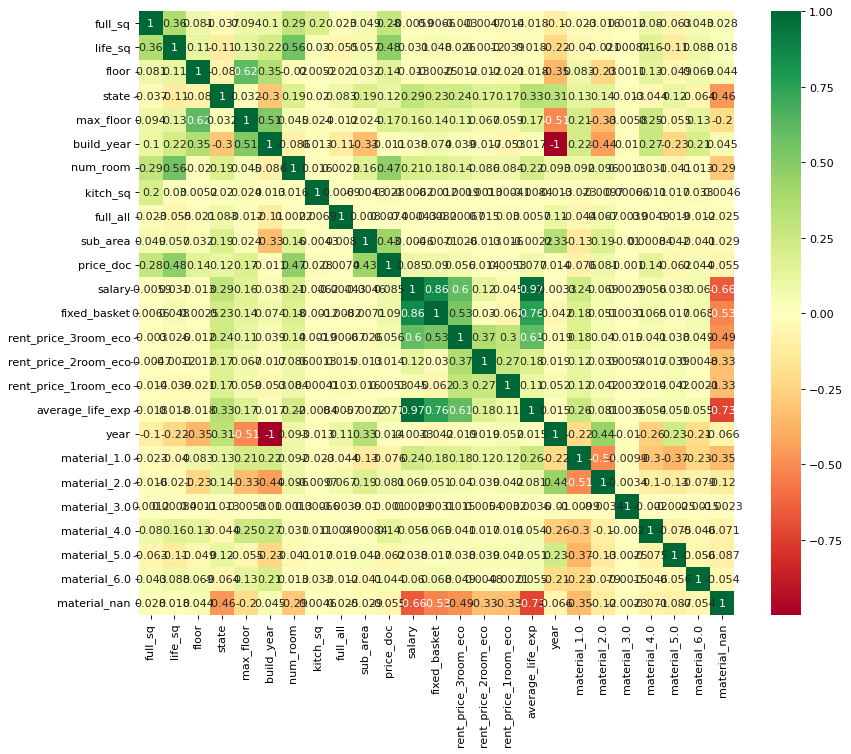

In [39]:
plt.figure(figsize=(12,10), dpi=80)
sns.heatmap(train.corr(), xticklabels=train.corr().columns, 
            yticklabels=train.corr().columns, cmap='RdYlGn', center=0, annot=True)

In [40]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15090 entries, 0 to 15089
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   full_sq               15090 non-null  int64  
 1   life_sq               15090 non-null  float64
 2   floor                 15090 non-null  float64
 3   state                 15090 non-null  float64
 4   max_floor             15090 non-null  float64
 5   build_year            15090 non-null  int64  
 6   num_room              15090 non-null  float64
 7   kitch_sq              15090 non-null  float64
 8   full_all              15090 non-null  int64  
 9   sub_area              15090 non-null  int64  
 10  price_doc             15090 non-null  int64  
 11  salary                15090 non-null  float64
 12  fixed_basket          15090 non-null  float64
 13  rent_price_3room_eco  15090 non-null  float64
 14  rent_price_2room_eco  15090 non-null  float64
 15  rent_price_1room_ec

In [41]:
# Откуда-то получились дикие выбросы в площадях квартир
print(train[train['full_sq']>1000].index)
train = train[train['full_sq']<1000]
print(train[train['life_sq']>500].index)
train = train[train['life_sq']<500]
print(train[train['kitch_sq']>500].index)
train = train[train['kitch_sq']<500]

Int64Index([11943], dtype='int64')
Int64Index([10794], dtype='int64')
Int64Index([4393, 8181, 10719, 14950], dtype='int64')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


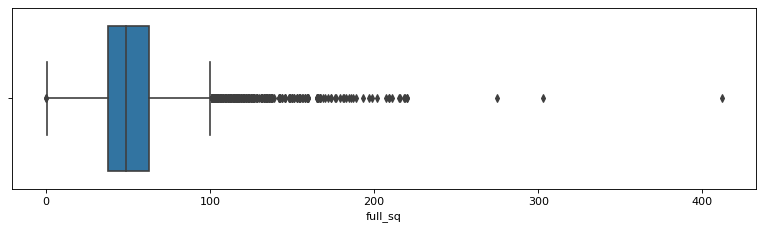

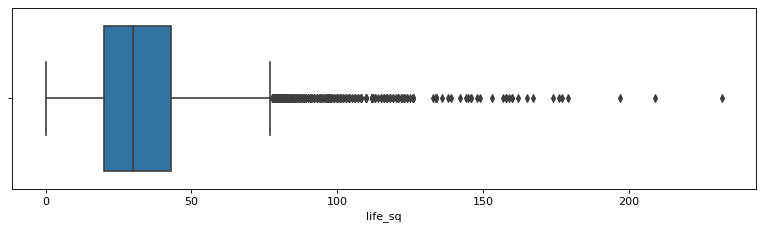

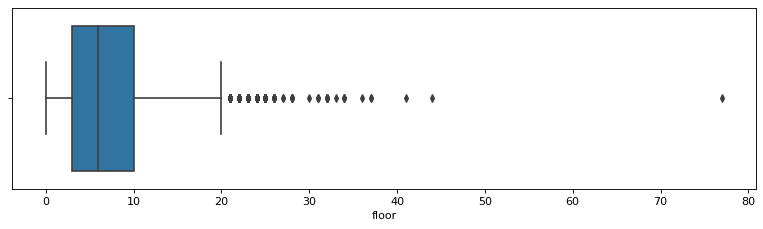

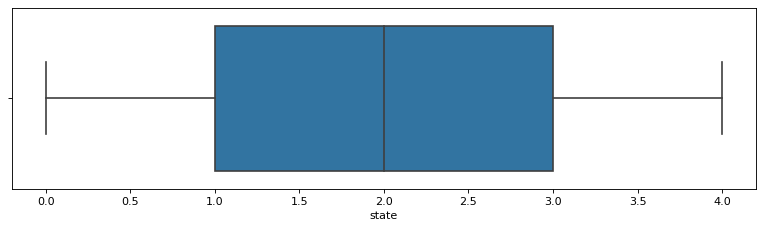

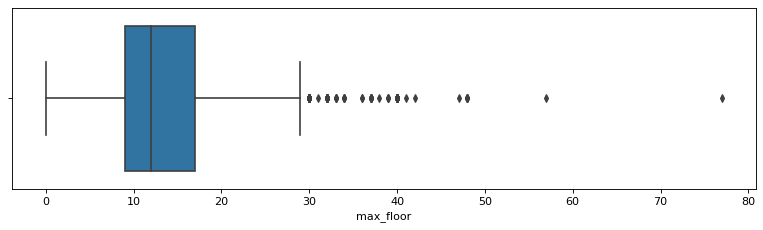

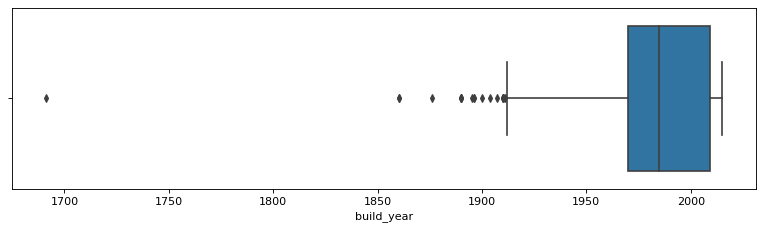

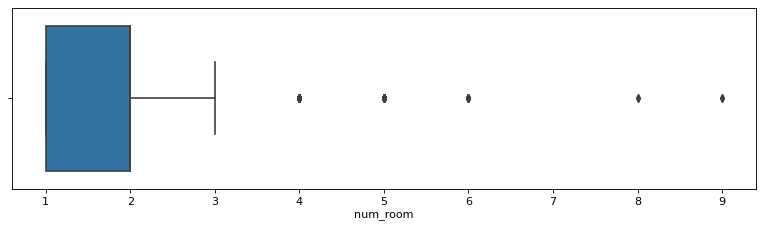

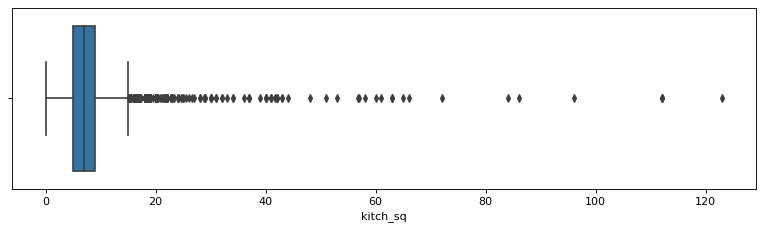

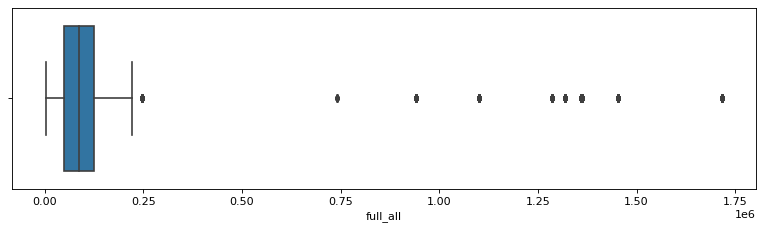

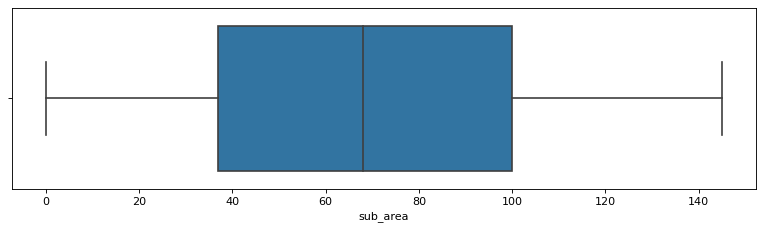

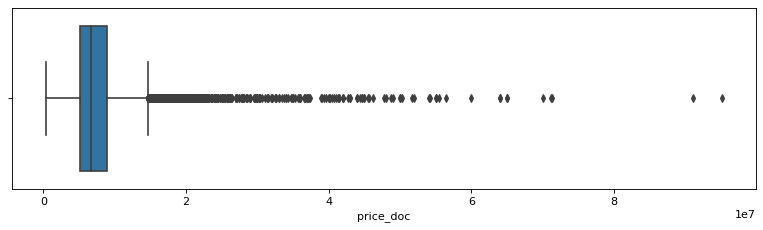

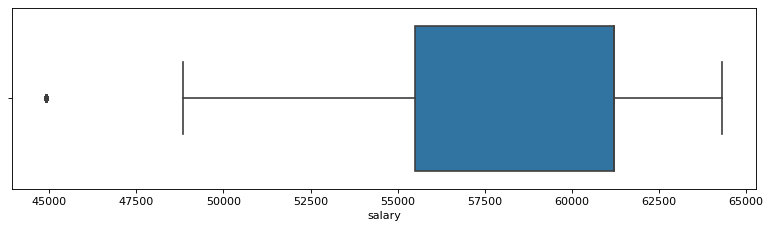

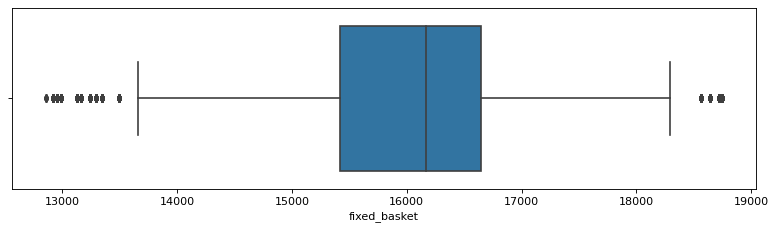

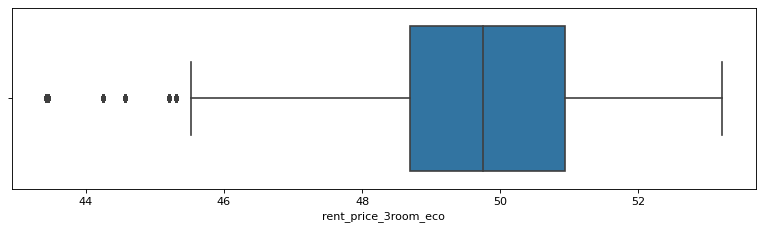

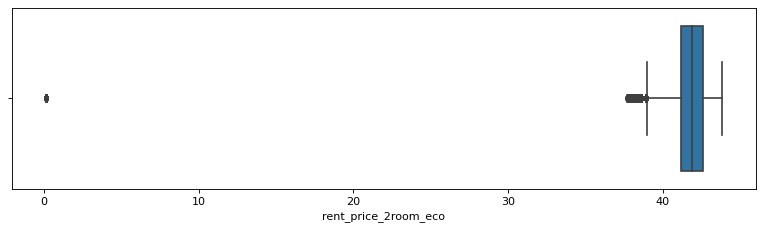

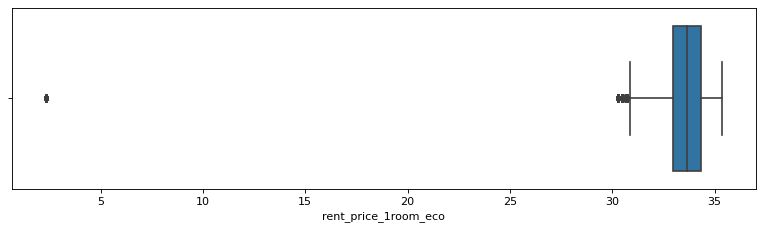

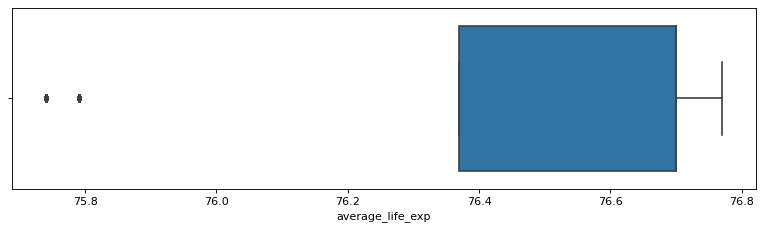

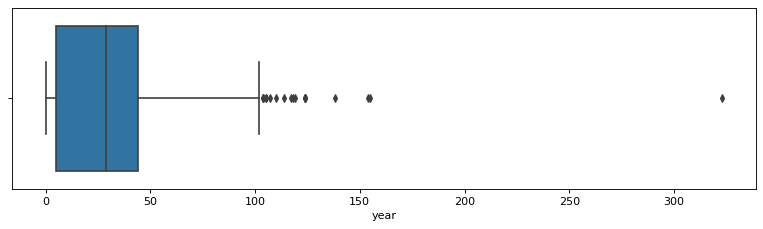

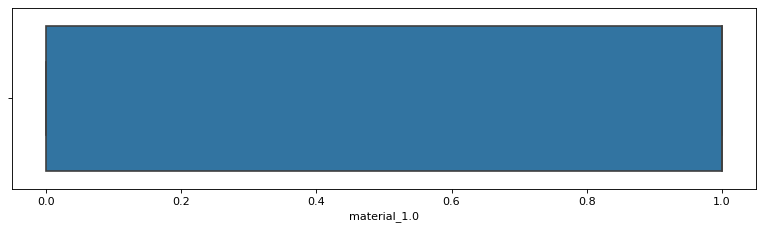

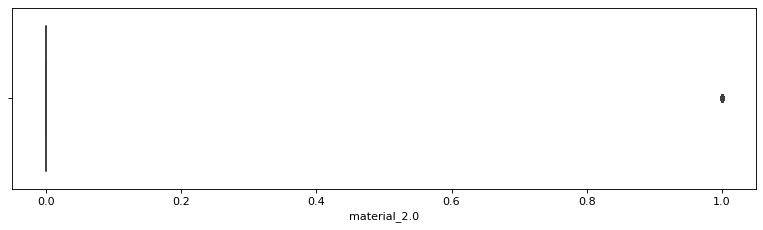

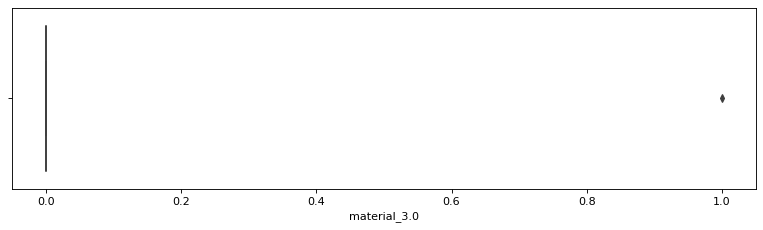

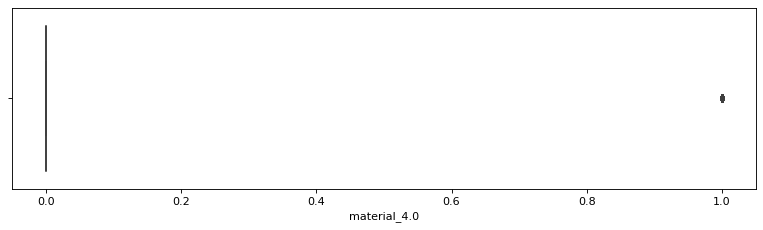

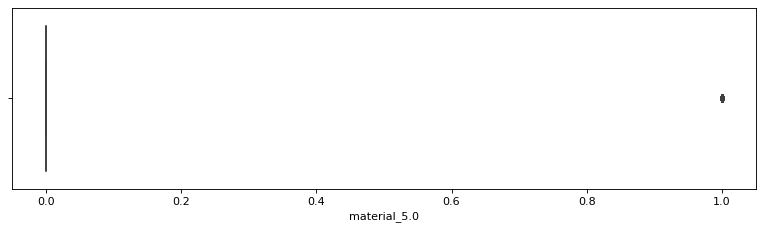

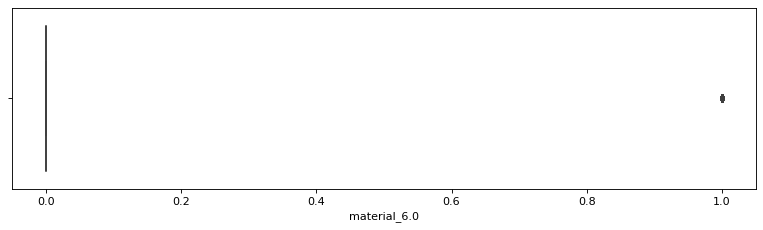

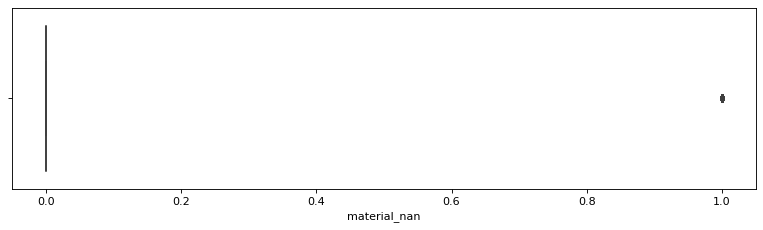

In [42]:
for index in train.columns:
    plt.figure(figsize=(12,3), dpi=80)
    sns.boxplot(x=train[index])

In [43]:
#Убираем выбросы
# Из full_all я не знаю, как лучше убрать выбросы: в среднем в районах живёт ~200к человек, а может жить до полутора миллонов
print(train[train['full_sq']>250].index)
train = train[train['full_sq']<250]
print(train[train['life_sq']>185].index)
train = train[train['life_sq']<185]
print(train[train['kitch_sq']>80].index)
train = train[train['kitch_sq']<80]

print(train[train['floor']>40].index)
train = train[train['floor']<40]
print(train[train['max_floor']>45].index)
train = train[train['max_floor']<45]

print(train[train['build_year']<1800].index)
train = train[train['build_year']>1800]

# информация из macro.csv
print(train[train['rent_price_2room_eco']<30].index)
train = train[train['rent_price_2room_eco']>30]
print(train[train['rent_price_1room_eco']<30].index)
train = train[train['rent_price_1room_eco']>30]

train.reset_index(drop=True, inplace=True)

Int64Index([5289, 8047, 9235], dtype='int64')
Int64Index([3477, 10446], dtype='int64')
Int64Index([1319, 3891, 7787, 7950, 8305, 8698, 10590], dtype='int64')
Int64Index([2808, 4081, 13159], dtype='int64')
Int64Index([4316, 8438, 9568, 11309, 13696], dtype='int64')
Int64Index([9668], dtype='int64')
Int64Index([  853,   926,  1282,  2547,  2577,  4323,  4452,  4665,  5294,
             5433,  5502,  5513,  6447,  7343,  7546,  7782,  7839,  7947,
             8119,  8178,  8198,  8513,  8639,  9527, 10937, 11043, 12309,
            12522, 12545, 13063, 13244, 13363, 13571, 13935, 14253],
           dtype='int64')
Int64Index([   77,    97,   181,   783,  1465,  1500,  1694,  2224,  2410,
             2439,  2677,  2915,  3047,  3089,  3799,  4132,  4392,  4604,
             4648,  5050,  5422,  5843,  5896,  5932,  6228,  6264,  6353,
             6611,  6681,  6918,  7522,  7605,  7715,  7872,  8319,  8939,
             9088, 10211, 10260, 10344, 10476, 10745, 10800, 10836, 12083,
      

In [44]:
train

,full_sq,life_sq,floor,state,max_floor,build_year,num_room,kitch_sq,full_all,sub_area,...,rent_price_1room_eco,average_life_exp,year,material_1.0,material_2.0,material_3.0,material_4.0,material_5.0,material_6.0,material_nan
0,42,28.0,8.0,2.0,9.0,1969,2.0,6.0,43795,34,...,33.97,76.37,44,1,0,0,0,0,0,0
1,55,41.0,4.0,3.0,5.0,1960,3.0,5.0,21040,133,...,33.15,76.37,53,0,1,0,0,0,0,0
2,43,29.0,4.0,2.0,5.0,1960,2.0,5.0,157010,44,...,34.55,76.37,53,0,1,0,0,0,0,0
3,62,35.0,15.0,0.0,22.0,1985,2.0,10.0,178264,92,...,33.15,76.37,28,1,0,0,0,0,0,0
4,80,55.0,15.0,1.0,24.0,2015,3.0,12.0,76284,101,...,31.09,76.77,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14960,69,48.0,2.0,2.0,4.0,1950,3.0,7.0,101982,57,...,35.37,76.70,64,0,1,0,0,0,0,0
14961,78,75.0,4.0,1.0,17.0,2014,3.0,1.0,247469,24,...,35.37,76.70,0,1,0,0,0,0,0,0
14962,38,19.0,15.0,3.0,17.0,1990,1.0,8.0,101708,118,...,33.26,76.70,24,1,0,0,0,0,0,0
14963,54,32.0,11.0,3.0,16.0,1979,2.0,9.0,178264,92,...,34.53,76.37,34,1,0,0,0,0,0,0


# Решение

## Градиентный бустинг из sklearn

In [45]:
X = train.drop(columns=['price_doc', 'build_year'])
X_val = test.drop(columns=['build_year'])
y = train['price_doc']

In [46]:
'''# Здесь должен быть отбор переменных
selector = SelectKBest(f_regression, k=5)
selector.fit(X, y)
X_new = selector.transform(X)
test_new = selector.transform(test)
cols = selector.get_support(indices=True)

# результаты отбора
print(X.columns)
print(X.columns[cols])
print()
ax = plt.subplots(figsize=(10,5))
plt.bar([i for i in range(len(selector.scores_))], selector.scores_)
plt.show()

X = X[X.columns[cols]]
test = test[test.columns[cols]]'''

'# Здесь должен быть отбор переменных\nselector = SelectKBest(f_regression, k=5)\nselector.fit(X, y)\nX_new = selector.transform(X)\ntest_new = selector.transform(test)\ncols = selector.get_support(indices=True)\n\n# результаты отбора\nprint(X.columns)\nprint(X.columns[cols])\nprint()\nax = plt.subplots(figsize=(10,5))\nplt.bar([i for i in range(len(selector.scores_))], selector.scores_)\nplt.show()\n\nX = X[X.columns[cols]]\ntest = test[test.columns[cols]]'

In [47]:
print(X.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14965 entries, 0 to 14964
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   full_sq               14965 non-null  int64  
 1   life_sq               14965 non-null  float64
 2   floor                 14965 non-null  float64
 3   state                 14965 non-null  float64
 4   max_floor             14965 non-null  float64
 5   num_room              14965 non-null  float64
 6   kitch_sq              14965 non-null  float64
 7   full_all              14965 non-null  int64  
 8   sub_area              14965 non-null  int64  
 9   salary                14965 non-null  float64
 10  fixed_basket          14965 non-null  float64
 11  rent_price_3room_eco  14965 non-null  float64
 12  rent_price_2room_eco  14965 non-null  float64
 13  rent_price_1room_eco  14965 non-null  float64
 14  average_life_exp      14965 non-null  float64
 15  year               

In [48]:
#X_train, X_test, y_train, y_test = train_test_split(X[X.columns[cols]], y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_train.head())
X_train.head()

(11972, 23) (2993, 23) (11972,) (2993,)
10308    18000000
367       4498010
9967      6900000
416       4900000
2420      6100000
Name: price_doc, dtype: int64


,full_sq,life_sq,floor,state,max_floor,num_room,kitch_sq,full_all,sub_area,salary,...,rent_price_1room_eco,average_life_exp,year,material_1.0,material_2.0,material_3.0,material_4.0,material_5.0,material_6.0,material_nan
10308,77,53.0,5.0,3.0,5.0,3.0,9.000000,116742,77,61208.0,...,34.30,76.70,80,0,1,0,0,0,0,0
367,43,43.0,6.0,0.0,6.0,1.0,5.918196,221709,39,55485.2,...,32.55,76.37,16,0,0,0,0,0,0,1
9967,35,18.0,10.0,0.0,12.0,1.0,8.000000,112804,104,61208.0,...,33.65,76.70,32,0,1,0,0,0,0,0
416,30,18.0,6.0,2.0,9.0,1.0,5.000000,157010,44,61208.0,...,32.96,76.70,44,0,1,0,0,0,0,0
2420,40,20.0,9.0,3.0,12.0,1.0,8.000000,165727,83,61208.0,...,34.30,76.70,34,1,0,0,0,0,0,0


In [49]:
from sklearn.ensemble import GradientBoostingRegressor
''' Градиентный бустинг sklearn
reg = GradientBoostingRegressor()
parameters = {'loss':['absolute_error'],
              'n_estimators':[100,300,500,700,1000],
              'learning_rate':[.001,0.01,.1],
              'max_depth':[1,2,4],
              'subsample':[.5,.75,1],
              'random_state':[42]}
# Поиск по заданным параметрам по 3 кросс-валидированным выборкам
gridsearch = GridSearchCV(reg,parameters,n_jobs=-1,scoring='neg_mean_absolute_error',cv=3)
gridsearch.fit(X,y)
gridsearch.best_params_'''
#{'learning_rate': 0.1,
# 'loss': 'absolute_error',
# 'max_depth': 4,
# 'n_estimators': 1000,
# 'random_state': 42,
# 'subsample': 0.75}

" Градиентный бустинг sklearn\nreg = GradientBoostingRegressor()\nparameters = {'loss':['absolute_error'],\n              'n_estimators':[100,300,500,700,1000],\n              'learning_rate':[.001,0.01,.1],\n              'max_depth':[1,2,4],\n              'subsample':[.5,.75,1],\n              'random_state':[42]}\n# Поиск по заданным параметрам по 3 кросс-валидированным выборкам\ngridsearch = GridSearchCV(reg,parameters,n_jobs=-1,scoring='neg_mean_absolute_error',cv=3)\ngridsearch.fit(X,y)\ngridsearch.best_params_"

In [50]:
# Обучение и проверка модели (best 1456632.5875572595)
reg = GradientBoostingRegressor(learning_rate=.1,
                                loss='absolute_error',
                                max_depth=4,
                                n_estimators=1000,
                                random_state=42,
                                subsample=0.75)

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(mean_squared_error(y_test, y_pred, squared=False))
print(mean_absolute_error(y_test, y_pred))

2797346.2217209903
1456632.5875572595


In [51]:
submission = pd.read_csv('/kaggle/input/mlurfuflat/submission.csv')
submission

,id,price_doc
0,0,10000
1,1,10000
2,2,10000
3,3,10000
4,4,10000
...,...,...
3769,3769,10000
3770,3770,10000
3771,3771,10000
3772,3772,10000


In [52]:
# Загрузка результата на сервер
reg = GradientBoostingRegressor(learning_rate=.1,
                                loss='absolute_error',
                                max_depth=4,
                                n_estimators=1000,
                                random_state=42,
                                subsample=0.75)

reg.fit(X, y)
final_pred = reg.predict(X_val)
prediction = pd.DataFrame(final_pred)
submission['price_doc'] = prediction
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         3774 non-null   int64  
 1   price_doc  3774 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 59.1 KB


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [53]:
submission.to_csv('check_sk.csv',index=False)

# Градиентный бустинг catboost

In [54]:
import catboost as cat

'''
reg = cat.CatBoostRegressor()
# -1457933.8635844202
parameters = {'loss_function':['MAE'],
              'learning_rate':[.08],
              'max_depth':[7],
              'subsample': [.7],
              'n_estimators': [500],
              'reg_lambda': [7],
              'silent': [True]
             }

# Поиск по заданным параметрам по 5 кросс-валидированным выборкам
gridsearch = GridSearchCV(reg,parameters,scoring='neg_mean_absolute_error',cv=5)
gridsearch.fit(X,y)
print(gridsearch.best_score_)
gridsearch.best_params_
'''

"\nreg = cat.CatBoostRegressor()\n# -1457933.8635844202\nparameters = {'loss_function':['MAE'],\n              'learning_rate':[.08],\n              'max_depth':[7],\n              'subsample': [.7],\n              'n_estimators': [500],\n              'reg_lambda': [7],\n              'silent': [True]\n             }\n\n# Поиск по заданным параметрам по 5 кросс-валидированным выборкам\ngridsearch = GridSearchCV(reg,parameters,scoring='neg_mean_absolute_error',cv=5)\ngridsearch.fit(X,y)\nprint(gridsearch.best_score_)\ngridsearch.best_params_\n"

In [55]:
# Обучение и проверка модели (best 1448330.2474362387)
reg = cat.CatBoostRegressor(learning_rate=0.08,
                            loss_function='MAE',
                            max_depth=7,
                            n_estimators=500,
                            reg_lambda=7,
                            subsample=0.8,
                            silent=True)

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(mean_squared_error(y_test, y_pred, squared=False))
print(mean_absolute_error(y_test, y_pred))

2805045.2590789334
1448330.2474362387


In [56]:
submission = pd.read_csv('/kaggle/input/mlurfuflat/submission.csv')
submission

,id,price_doc
0,0,10000
1,1,10000
2,2,10000
3,3,10000
4,4,10000
...,...,...
3769,3769,10000
3770,3770,10000
3771,3771,10000
3772,3772,10000


In [57]:
reg = cat.CatBoostRegressor(learning_rate=0.08,
                            loss_function='MAE',
                            max_depth=7,
                            n_estimators=500,
                            reg_lambda=7,
                            subsample=0.8,
                            silent=True)
reg.fit(X, y)
# Загрузка результата на сервер
final_pred = reg.predict(X_val)
prediction = pd.DataFrame(final_pred)
submission['price_doc'] = prediction
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         3774 non-null   int64  
 1   price_doc  3774 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 59.1 KB


In [58]:
submission.to_csv('check_cat.csv',index=False)